# Лабораторная работа 3. Линейные методы.

In [608]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, LogisticRegressionCV
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_score, auc, accuracy_score, confusion_matrix
from sklearn.datasets import load_digits
import matplotlib.pylab as plt
%matplotlib inline

In [85]:
import datetime as dte

In [86]:
data = pd.read_csv('Bikes_rent_day.csv', sep = ',')

In [135]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [287]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [350]:
X, y = data[data.columns[:-1]], data[data.columns[-1]]

In [351]:
X.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered'],
      dtype='object')

In [352]:
sum(y!=data.cnt)

0

Исключим признак dteday, поскольку вся информация о днях недели, сезонах и месяцах, необходимая для выявления закономерностей, есть. Кроме того, не имееет смысла считать среднее из даты. Исключим также признаки casual и registry - как напрямую связанные с целевой переменной cnt(cnt=casual+registry)

In [353]:
X = X.drop(['dteday','registered', 'casual'], axis = 1)

Исключим признак instant(данные взяты с UCI, в описании признаков, рекомендованных к использованию в Лабораторной его нет)

In [354]:
X = X.drop(['instant'], axis = 1)

In [355]:
print(len(X.columns))
X.columns

11


Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')


Для каждого дня проката известны значения следующих признаков:
- season: 1 - весна, 2 - лето, 3 - осень, 4 - зима
- yr: 0 - 2011, 1 - 2012
- mnth: от 1 до 12 (соответственно январь - декабрь)
- holiday: 0 - нет праздника, 1 - есть праздник
- weekday: от 0 до 6 (соответственно понедельник - воскресенье)
- workingday: 0 - нерабочий день, 1 - рабочий день
- workthersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
- temp: температура в Цельсиях
- atemp: температура по ощущениям в Цельсиях
- hum: влажность
- windspeed(mph): скорость ветра в милях в час
- windspeed(ms): скорость ветра в метрах в секунду
- cnt: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

In [356]:
XX = X


**(0.5 балла)** В начале попробуем посмотреть на признаки. Постройте матрицу коэффициентов корреляции Пирсона между признаками. Для этого можно воспользоваться методом датафрейма corr. Для удобства можно визуализировать ее как hot-map (пример, как это можно сделать, есть в семинаре про визуализацию). Можно ли сказать, что среди признаков есть линейно зависимые? Укажите какие?

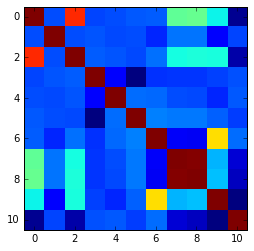

In [357]:
plt.imshow(X.corr(), interpolation='nearest')

Всего 3 коррелирующих между собой признаков


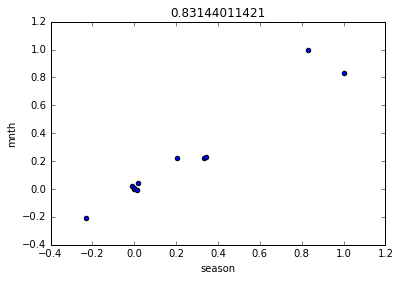

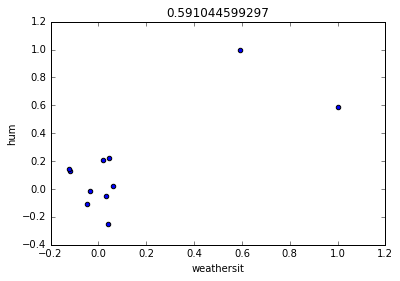

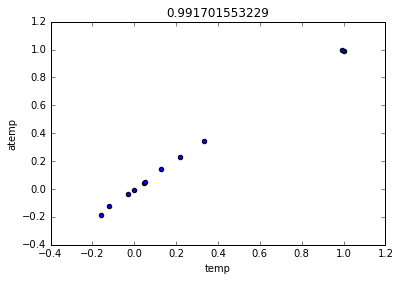

In [358]:
n_corr_feat = 0
corr_feat_list = []
pirs_matrix = X.corr()
for feature1_num in range(pirs_matrix.shape[0]):
    feature1_name = pirs_matrix.columns[feature1_num]
    for feature2_num in range(pirs_matrix.shape[0]):
        feature2_name = pirs_matrix.columns[feature2_num]
        corr_coef = pirs_matrix[feature1_name][feature2_name]
        if feature2_num>feature1_num and corr_coef>0.5: #  feature1_num>feature2_num to iterate only one half of the coo matrix
            n_corr_feat+=1
            for feature in [feature1_name, feature2_name]:
                if not feature in corr_feat_list:
                    corr_feat_list.append(feature)
            plt.scatter(pirs_matrix[feature1_name], pirs_matrix[feature2_name])
            plt.xlabel(feature1_name)
            plt.ylabel(feature2_name)
            plt.title(corr_coef)
            plt.figure()
print('Всего %d коррелирующих между собой признаков' % (n_corr_feat))

In [359]:
corr_feat_list

['season', 'mnth', 'weathersit', 'hum', 'temp', 'atemp']

In [360]:
len(corr_feat_list)

6


**(0.5 балла)** Выведите средние значения всех признаков. Можно ли сказать, что признаки имеют разный масштаб? В случае положительного ответа стандартизуйте признаки (из признака вычитается среднее и делится на стандартное отклонение), применив функцию scale.

In [361]:
X.mean()

season        2.496580
yr            0.500684
mnth          6.519836
holiday       0.028728
weekday       2.997264
workingday    0.683995
weathersit    1.395349
temp          0.495385
atemp         0.474354
hum           0.627894
windspeed     0.190486
dtype: float64

In [362]:
X.mean().shape[0]

11

In [363]:
scale(X)

array([[-1.34821315, -1.00136893, -1.60016072, ..., -0.67994602,
         1.25017133, -0.38789169],
       [-1.34821315, -1.00136893, -1.60016072, ..., -0.74065231,
         0.47911298,  0.74960172],
       [-1.34821315, -1.00136893, -1.60016072, ..., -1.749767  ,
        -1.33927398,  0.74663186],
       ..., 
       [-1.34821315,  0.99863295,  1.58866019, ..., -1.42434419,
         0.87839173, -0.85355213],
       [-1.34821315,  0.99863295,  1.58866019, ..., -1.49004895,
        -1.01566357,  2.06944426],
       [-1.34821315,  0.99863295,  1.58866019, ..., -1.54048197,
        -0.35406086, -0.46020122]])

In [364]:
if np.any((np.array(X.mean())/np.array(X.mean()).reshape(X.mean().shape[0],1))>=10):
    X = scale(X)

In [365]:
X.shape

(731, 11)


**(1 балл)** Теперь попробуем обучить модель регрессии. Линейные модели реализованы в модуле sklearn.linear_model. Создайте объект LinearRegression с параметрами по умолчанию, обучите его на всех данных X и ответах y, а затем для каждого признака выведите его название (хранятся в после columns исходного датафрейма) и вес (веса хранятся в переменной coef_ класса регрессора).

In [366]:
LNR = LinearRegression()

In [367]:
LNR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [368]:
importance_dict = {}
for i in range(len(XX.columns)):
    importance_dict[XX.columns[i]] = LNR.coef_[i]
    print('Коэффициент признака',XX.columns[i],'равен', LNR.coef_[i])
sorted(importance_dict.items(), key=lambda s: s[1], reverse=True)

Коэффициент признака season равен 565.87445338
Коэффициент признака yr равен 1020.35074609
Коэффициент признака mnth равен -134.461991096
Коэффициент признака holiday равен -86.6926045155
Коэффициент признака weekday равен 138.360292869
Коэффициент признака workingday равен 55.9557769436
Коэффициент признака weathersit равен -332.695568038
Коэффициент признака temp равен 371.140994604
Коэффициент признака atemp равен 581.906559001
Коэффициент признака hum равен -145.016239461
Коэффициент признака windspeed равен -198.070543979


[('yr', 1020.3507460886486),
 ('atemp', 581.90655900117213),
 ('season', 565.8744533798872),
 ('temp', 371.14099460440758),
 ('weekday', 138.36029286893611),
 ('workingday', 55.955776943598046),
 ('holiday', -86.692604515516507),
 ('mnth', -134.46199109613042),
 ('hum', -145.0162394610438),
 ('windspeed', -198.07054397855771),
 ('weathersit', -332.69556803804289)]

*Самые важные признаки*

In [369]:
sort_important_feat = sorted(importance_dict.items(), key=lambda s: s[1], reverse=True)
for feature, coef in sort_important_feat[:3]:
    print(feature, coef)

yr 1020.35074609
atemp 581.906559001
season 565.87445338



**(2 балла)** Обучите регрессоры Lasso и Ridge с параметрами по умолчанию, выведите значения весов аналогично тому как это делалось ранее и убедитесь, что описанная проблема решена.

**Lasso**

In [370]:
L = Lasso()

In [371]:
L.fit(X,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [372]:
importance_dict = {}
for i in range(len(XX.columns)):
    importance_dict[XX.columns[i]] = L.coef_[i]
    print('Коэффициент признака',XX.columns[i],'равен', L.coef_[i])
sorted(importance_dict.items(), key=lambda s: s[1], reverse=True)

Коэффициент признака season равен 560.241616031
Коэффициент признака yr равен 1019.46349407
Коэффициент признака mnth равен -128.730627037
Коэффициент признака holiday равен -86.1527813337
Коэффициент признака weekday равен 137.347893905
Коэффициент признака workingday равен 55.2123706414
Коэффициент признака weathersit равен -332.369856962
Коэффициент признака temp равен 376.36323621
Коэффициент признака atemp равен 576.530793505
Коэффициент признака hum равен -144.129155003
Коэффициент признака windspeed равен -197.13968943


[('yr', 1019.4634940657239),
 ('atemp', 576.53079350469568),
 ('season', 560.24161603089988),
 ('temp', 376.3632362095596),
 ('weekday', 137.34789390496556),
 ('workingday', 55.212370641359271),
 ('holiday', -86.152781333710479),
 ('mnth', -128.73062703678417),
 ('hum', -144.12915500344522),
 ('windspeed', -197.13968943041752),
 ('weathersit', -332.36985696237701)]

In [373]:
sort_important_feat = sorted(importance_dict.items(), key=lambda s: s[1], reverse=True)
for feature, coef in sort_important_feat[:3]:
    print(feature, coef)

yr 1019.46349407
atemp 576.530793505
season 560.241616031


**Ridge**

In [374]:
R = Ridge()

In [375]:
R.fit(X,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [376]:
importance_dict = {}
for i in range(len(XX.columns)):
    importance_dict[XX.columns[i]] = R.coef_[i]
    print('Коэффициент признака',XX.columns[i],'равен', R.coef_[i])
sorted(importance_dict.items(), key=lambda s: s[1], reverse=True)

Коэффициент признака season равен 563.083004978
Коэффициент признака yr равен 1018.95451132
Коэффициент признака mnth равен -131.868751248
Коэффициент признака holiday равен -86.7453880627
Коэффициент признака weekday равен 138.008167991
Коэффициент признака workingday равен 55.9067108661
Коэффициент признака weathersit равен -332.388526726
Коэффициент признака temp равен 386.294189353
Коэффициент признака atemp равен 566.518577136
Коэффициент признака hum равен -145.015555536
Коэффициент признака windspeed равен -198.35702165


[('yr', 1018.9545113222619),
 ('atemp', 566.51857713590016),
 ('season', 563.08300497829032),
 ('temp', 386.29418935349344),
 ('weekday', 138.00816799103913),
 ('workingday', 55.906710866091593),
 ('holiday', -86.745388062666436),
 ('mnth', -131.86875124812653),
 ('hum', -145.0155555361755),
 ('windspeed', -198.35702165023687),
 ('weathersit', -332.38852672555385)]

In [377]:
sort_important_feat = sorted(importance_dict.items(), key=lambda s: s[1], reverse=True)
for feature, coef in sort_important_feat[:3]:
    print(feature, coef)

yr 1018.95451132
atemp 566.518577136
season 563.083004978


**(1 балл)** Для каждого значения коэффициента регуляризации из alphas создайте регрессор Lasso, указав в качестве параметра соответствующее значение alpha, обучите его на объектах X и ответах y и запишите полученные веса в соответствующую строку матрицы coefs_lasso, а затем проделайте то же самое для регрессора Ridge и переменной coefs_ridge.

In [378]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

In [379]:
type(Lasso)

abc.ABCMeta

In [380]:
models_L_R = {Lasso:coefs_lasso,Ridge:coefs_ridge}
for model in models_L_R:
    ##  сохраняем используемую модель не как объект, а как базовый абстрактный класс ABCMeta,
    ## чтобы циклично обучать созданный на его основе объект
    model_current = model 
    for alpha_ind in range(alphas.shape[0]):
        model = model_current
        model = model(alpha=alphas[alpha_ind])
        model.fit(X,y)
        models_L_R[model_current][alpha_ind] = model.coef_                

In [381]:
coefs_lasso.shape

(10, 11)

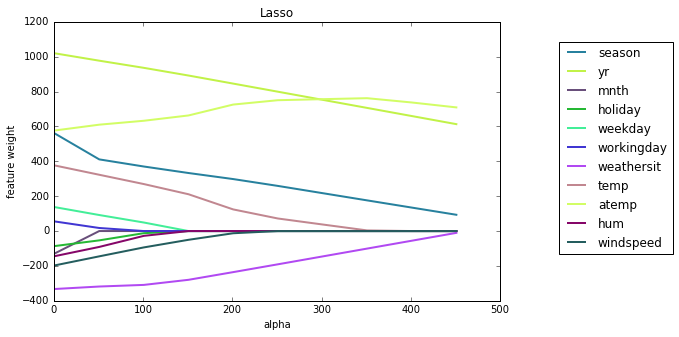

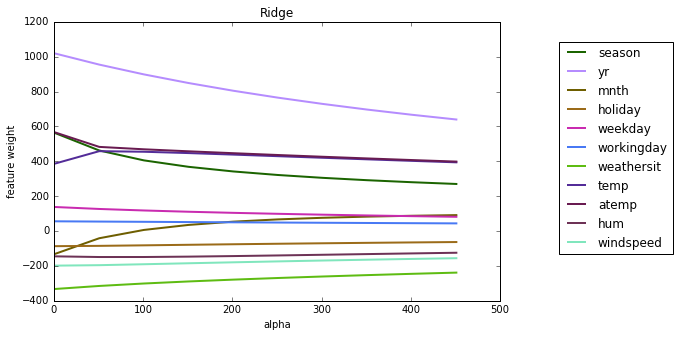

In [390]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, XX.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth = 2)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, XX.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth = 2)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [385]:
L = Lasso(alpha=999999)
L.fit(X,y)
L.coef_

array([ 0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.])

In [386]:
R = Ridge(alpha=9999999999999999999)
R.fit(X,y)
R.coef_

array([  5.74685887e-14,   8.01969402e-14,   3.96204748e-14,
        -9.67210832e-15,   9.54413738e-15,   8.65439406e-15,
        -4.20848047e-14,   8.87987250e-14,   8.93041666e-14,
        -1.42445216e-14,  -3.31912280e-14])


**(2 балла)** Ответьте на вопросы ниже.
- Какой регрессор (Ridge или Lasso) агрессивнее уменьшает веса? - Lasso
- Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит. - Веса обнулятся, поскольку Lasso использует L1 норму регуляризации и пространство весов представляет собой ромб(в двумерном случае) и пресечение его с пространством ф-ла качества(эллипс) будет лежать на вершинах ромба при большинстве вариантов расположений эллипса. Один из признаков в двумерном случае, группы признаков в многомерном будут обнуляться.
- Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha? А Ridge? Lasso исключает при  alpha>=201, Ridge практически не меняет значение
- Какой из регрессоров подойдет для отбора неинформативных признаков? Lasso, поскольку такие признаки исключаются

# Линейная классификация

**(0.2 балла)** Посчитайте сколько различных классов цифр есть в данных, а также сколько в каждом классе содержится объектов.

In [395]:
data = load_digits()

In [403]:
print('Кол-во классов:',len(set(data.target)))

Кол-во классов: 10


In [424]:
pd.DataFrame(data.target)[0].value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
Name: 0, dtype: int64

In [427]:
for class_number in range(len(set(data.target))):
    n_samples_in_class = pd.DataFrame(data.target)[0].value_counts()[class_number]
    print('Классу %d принадлежит %d объектов или %.2f %% всех объектов' % 
          (class_number, n_samples_in_class, float(n_samples_in_class)*100/data.target.shape[0]))

Классу 0 принадлежит 178 объектов или 9.91 % всех объектов
Классу 1 принадлежит 182 объектов или 10.13 % всех объектов
Классу 2 принадлежит 177 объектов или 9.85 % всех объектов
Классу 3 принадлежит 183 объектов или 10.18 % всех объектов
Классу 4 принадлежит 181 объектов или 10.07 % всех объектов
Классу 5 принадлежит 182 объектов или 10.13 % всех объектов
Классу 6 принадлежит 181 объектов или 10.07 % всех объектов
Классу 7 принадлежит 179 объектов или 9.96 % всех объектов
Классу 8 принадлежит 174 объектов или 9.68 % всех объектов
Классу 9 принадлежит 180 объектов или 10.02 % всех объектов



Для оценивания качества алгоритма будем использовать отложенную выборку. Воспользуйтесь функцией train_test_split чтобы разделить данные на обучающие и тестовые. Важно, чтобы от перезапуска ваше разбиение не менялось, кроме того соотношение классов между собой соранялось. Для этого вам понадобится установить следующие дополнительные значения у данной функции:
- test_size или train_size (любой на выбор) — установите параметр таким образом, чтобы в тестовую выборку попала половина всех примеров
- random_state — необходимо задать некоторое число (любое на ваш выбор), чтобы разбиение оставалось фиксированным не зависимо от запуска
- stratify — необходимо задать, чтобы соотношение классов в исходной выборке и новых совпадало; для этого нужно передать значение поля target

In [465]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size = 0.5, random_state=1, stratify=data.target)

In [466]:
X_train.shape

(896, 64)

In [467]:
y_train.shape

(896,)


Для начала будем решать задачу бинарной классификации, а именно попробуем отделить цифру 8 от всех остальных. Создайте новую переменную, которая будет аналогично переменной target (своя для обучающей и тестовой выборки), в которой будет стоять 1, если соответствующая метка "8" и -1 в остальных случаях.

In [472]:
yy_train, yy_test = (y_train==8)+0,(y_test==8)+0
yy_train[yy_train==0] = -1
yy_test[yy_test==0] = -1

In [475]:
print(sum((y_train==8)+0)-sum((y_train!=8)+0)==sum(yy_train))
print(sum((y_test==8)+0)-sum((y_test!=8)+0)==sum(yy_test))

True
True



**(0.8 балла)** Сколько теперь получилось объектов положительного класса, а сколько — отрицательного? Какая метрика качества из изученных ранее подойдет для данной задачи и почему? Чем плохо использовать, например, Accuracy?

- Подойдут метрики precision(точность)-recall(полнота)
- accuracy плоха тем, что не учитывает неправильные ответы. Самый примитивный алгоритм, относящий все объекты к одному классу будет иметь долю правильных ответов равной доле положительного класса, т.е даст при несбалансированной выборке ложное представление об эффективности алгоритма

In [476]:
LGR = LogisticRegression()

Для начала зафиксируем схему кросс-валидации: будем использовать кросс-валидацию по 5 блокам. Для этого создайте объект KFold, которому необходимо задать размер выборки (обучающей), а также задать следующие параметры:
n_folds — число фолдов (5 в данном случае)
random_state — аналогично как было выше

In [478]:
kfold = KFold(X_train.shape[0],n_folds=5, random_state=1)


После этого можно приступить к подбору значения C. Будем перебирать значения по логарифмической шкале, а именно из множества [0.001, 0.01, 0.1, 1.0, 10]. В качестве оптимизируемой метрики выберем AUC-ROC.
В sklearn для логистической регрессии это можно сделать, например, следующим способом: воспользоваться классом LogisticRegressionCV. В этом случае вам необходимо задать следующие параметры:
- Cs — массив со значениями перебираемых параметров
- cv — схему кросс-валидации, с помощью которой будет осуществляться выбор наилучшего
- scoring — название способа оценивания качества; в данном случае это roc_auc
- random_state

Чтобы подобрать оптимальное C, вызовите метод fit.

**(2 балла)** Создайте объект класса LogisticRegressionCV, передав в качестве значения параметра Cs список [0.001, 0.01, 0.1, 1.0, 10], а в качестве cv — созданный ранее объект KFold. Обучите данный классификатор. Каким получилось оптимальное значение C?

In [586]:
Cs = [0.001, 0.01, 0.1, 1.0, 10]

In [587]:
LGRCV =LogisticRegressionCV(Cs = Cs, cv = kfold, random_state=1,scoring='roc_auc')

In [588]:
LGRCV.fit(X_train,yy_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1.0, 10], class_weight=None,
           cv=sklearn.cross_validation.KFold(n=896, n_folds=5, shuffle=False, random_state=1),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=1, refit=True, scoring='roc_auc', solver='lbfgs',
           tol=0.0001, verbose=0)

In [589]:
optim_c = LGRCV.C_[0]
print('Оптимальное значение C равно',optim_c)

Оптимальное значение C равно 0.01



Теперь создайте объект класса LogisticRegression со значением C равным оптимальному, найденному выше. Обучите его (используя метод fit), на всей обучающей выборке.

In [590]:
LGR = LogisticRegression(C=optim_c)

In [591]:
LGR.fit(X_train, yy_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Теперь пришло время посмотреть как полученный классификатор работает на тестовой выборке.

**(2 балла)** Для оценивания качества построим ROC и Precision-Recall кривые, а так же посчитаем площадь под ними. Для этого вам нужно сделать следующее:
- получите предсказание вероятности принадлежности положительному классу, используя метод predict_proba для тестовой выборки (обратите внимание, что в данном случае этот метод вернет 2 колонки — вероятности принадлежностей каждому классу, вам необходима первая, если считать с нуля).
- постройте график, на котором изобразите Precision-Recall кривую, используя функцию precision_recall_curve. Более подробно как построить такой график было рассказано на одном из семинаров. Вычислите площадь под этим графиком.
- проделайте аналогичные действия для ROC-кривой (воспользовавшись функцией roc_curve).

In [592]:
predict = LGR.predict_proba(X_test).transpose()[1]

In [633]:
precision,recall,smth = precision_recall_curve(yy_test, predict)

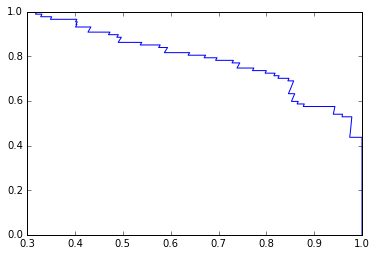

In [649]:
plt.plot(precision,recall)

In [647]:
print('Площадь под данной кривой равна',auc(recall,precision))

Площадь под данной кривой равна 0.847747267864


In [653]:
fpr,tpr,thresholds = roc_curve(yy_test, predict)

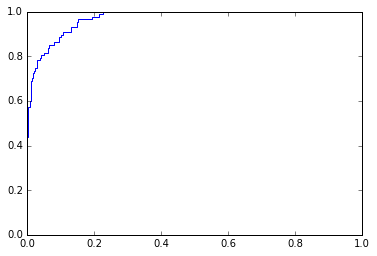

In [654]:
plt.plot(fpr,tpr)

In [656]:
print('Площадь под кривой roc',auc(fpr,tpr))

Площадь под кривой roc 0.97180095456



**(1 балл)** Теперь найдите, какую точность может иметь данный классификатор, чтобы полнота была не менее 0.8. Аналогично найдите какую максимальную полноту будет иметь классификатор при точности не менее 0.9.

In [598]:
df_prec_rec = pd.DataFrame(prec_rec, columns=['Precision', 'Recall'])

In [599]:
print('При полноте >=0.8 классификатор может иметь минимальную точность',
      min(df_prec_rec.ix[df_prec_rec["Recall"]>=0.8].Precision))
print('При полноте >=0.8 классификатор может иметь максимальную точность',
      max(df_prec_rec.ix[df_prec_rec["Recall"]>=0.8].Precision))
print('При полноте >=0.8 классификатор имеет среднюю точность',
      df_prec_rec.ix[df_prec_rec["Recall"]>=0.8].Precision.mean())

При полноте >=0.8 классификатор может иметь минимальную точность 0.0
При полноте >=0.8 классификатор может иметь максимальную точность 0.735632183908
При полноте >=0.8 классификатор имеет среднюю точность 0.4366971121781947


In [600]:
max(df_prec_rec["Precision"])

0.74712643678160917


А теперь вернемся к исходной многоклассовой задаче. Как известно, удобство sklearn заключается в том, что вам не нужно делать каких-либо модификаций алгоритмов в многоклассовом случае, так как все уже реализовано внутри библиотеки.

**(0.5 балла)** Обучите на исходной обучающей выборке логистическую регрессию. Постройте предсказания для тестовой выборки, используя метод predict. Посчитайте accuracy на тестовой выборке.

In [632]:
LGR = LogisticRegression(C = optim_c) ## при с==1 цифры путаются чаще

In [624]:
LGR.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [625]:
predict_multi = LGR.predict(X_test)

In [626]:
print('Доля правильных ответов:',accuracy_score(y_test,LGR.predict(X_test)))

Доля правильных ответов: 0.958934517203



**(1.5 балла)** Самое интересное — посмотреть на ошибки классификации. Для этого постройте confusion_matrix. Какие цифры путаются чаще всего между собой? Есть ли цифра, на которой на тестовой выборке классификатор ни разу не ошибся?

In [627]:
confusion_matrix(y_test, predict_multi)

array([[88,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 82,  0,  2,  0,  1,  1,  0,  5,  0],
       [ 0,  1, 88,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 87,  0,  2,  0,  0,  2,  1],
       [ 0,  1,  0,  0, 88,  0,  0,  1,  1,  0],
       [ 1,  0,  1,  0,  0, 88,  1,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  1, 88,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 88,  0,  1],
       [ 0,  4,  1,  1,  0,  0,  0,  0, 80,  1],
       [ 0,  1,  0,  1,  0,  1,  0,  0,  0, 87]])

Чаще всего путаются 8 и 1. Безошибочно классифицированной цифры нет.

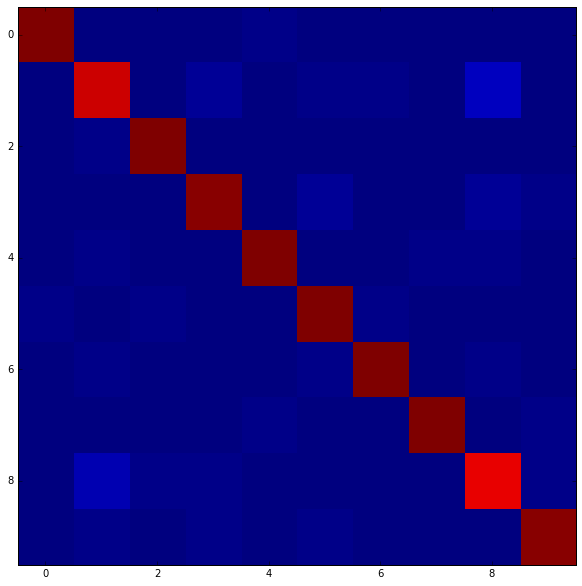

In [631]:
plt.figure(figsize=[10,10])
plt.imshow(confusion_matrix(y_test, predict_multi),interpolation='nearest')